# Getting Started

This is a mini-tutorial on getting started with `edges_estimate`. It aims to cover what you need to know to build and run simple EDGES models over data, view parts of the model, read in the output MCMC chains, and make some plots.

Since `edges_estimate` is a simple extension to the underlying Bayesian framework `yabf`, you'll also learn a bit of how to use that library (no prior familiarity with it is assumed). Nevertheless, more details of `yabf` can be learned by reading [its documentation](https://yabf.readthedocs.org).

## Setup

First we'll import the primary namespaces in `edges_estimate`:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import edges_estimate as ee

%matplotlib inline

In this tutorial we will exclusively use the low-band data from the Nature paper (Bowman et al. 2018). 
Note that this analysis was _not_ the analysis pipeline performed in that paper. Let's read in that publicly available data. Here, for simplicity, we have already converted the data into `.npy` format, which will be helpful later on:

In [2]:
freqs = np.load("edges_nature_data_freqs_full.npy")
temps = np.load("edges_nature_data_tsky_full.npy")

## Building a Model

There are two main ways to use `edges_estimate` (or indeed, `yabf`). One is via the command-line, using `YAML` configuration files. The other is directly in a python script. In this tutorial we'll show primarily the latter, though we will try to give an idea of the former as well.

`yabf` provides a way to create arbitrary hierarchically-nested Bayesian models from some simple building blocks. 
We may use these fundamental building blocks at times, but `edges_estimate` provides ready-made solutions for fitting EDGES data (as you may expect), and here we will mostly use these.

The general structure of a `yabf` model is as follows. The outermost structure is called a `LikelihoodContainer`, and this is a simple container that holds _independent_ likelihoods (that is, independent in the sense that their log-posterior values may simply be added to generate a total posterior). They are _not_ necessarily independent in terms of the parameters they use -- a single parameter may affect any number of likelihoods in the container.

As already mentioned, the second layer of the structure is a number of `Likelihood`s. Each of these has specific methods to calculate priors and likelihoods. In fact, if a single likelihood is used, that likelihood can form the top layer, and no `LikelihoodContainer` is required. Each likelihood can be given a number of `Parameter`s and also an arbitrary number of what we call `Component`s (we'll talk about these soon). The `Likelihood` uses the `Parameter` data to calculate its priors and internally passes them around to determine its likelihood. Note that in `yabf`, there is a distinction between active and passive parameters. Each `Likelihood`, as defined in code, has a number of predefined `Parameter`s, which define some attributes of the parameter. Nevertheless, in any given fit, only a subset of these need to be actually varied, and these become "active". What's more, active parameters defined at runtime may correspond to _more_ than one `Parameter` in _more_ than one likelihood, and this correspondence may occur through an arbitrary transformation. We will get into that later. The beauty of `yabf` is that the model is constructed in such a way that even if there are multiple connected parameters in the likelihoods, you can isolate each likelihood and it still works as expected.

The third layer of the structure are the `Component`s. These also can be defined with `Parameter`s, much like `Likelihood`s, but they do not calculate either priors or likelihoods. Instead, they are re-useable components that calculate parts of the forward-model. They are not necessary (the likelihood could contain a method to calculate the forward model itself), but they are useful because of this re-useability. Furthermore, `Component`s can contain `Component`s to an arbitrary hierarchical level. Again, while the parent `Likelihood` controls how each of the interdependent children `Component`s behave, it is quite possible to isolate a `Component` at an arbitrary level, and generate its own contribution just as you would expect. This makes interactive testing much simpler.

So how does this all work together? The general workflow can be stated as containing two parts: setup and evaluation. At setup (which happens at the creation of a `LikelihoodContainer` or `Likelihood` instance) the following happens:
1. The `Likelihood` determines an ordered list of its `Component`s, and each of them do the same for their subcomponents. A full ordered list of all subcomponents (down to arbitrary level) is available at each level. 
2. The `Parameter`s given by the user at all levels of the heirarchy are gathered and compared -- those with the same name are assumed to be the same parameter (i.e. a single number will be passed to both), even if their class-definition name is not the same. 
3. A mapping is built from input parameter name to a full hierarchical dictionary of parameters, so that any function call to which parameters are given can be propagated.

At evaluation, the following happens:
1. Given a `Likelihood` instance called `lk`, we _call_ the instance, and in the simplest case, we pass it a map of input parameters. These parameters correspond to the _active_ parameter names. Not all active parameters must be given (though they will in an MCMC run) -- those that are not will receive default values (which can also be defined/overwritten at instantiation).
2. These parameters are deployed down the graph using the parameter mapping.
3. The tree of `Component`s is evaluated, from bottom-up. Each component has a single method which calculates an arbitrary dataset and adds it to an internal `ctx` dictionary under a key specified by the `Component` definition. parent `Component`s then have access to any of the data generated by their children, and may modify it or add to it.
4. Finally, the `Likelihood` receives the full `ctx` dictionary (along with its active parameters), and performs three steps:
    a. It performs a `reduce` step, in which it reduces that data into the most dense form possible before comparison with data
    b. It calculates the `posterior` by comparing the output of the reduction (termed the `model`) with data.
    c. It calculates priors for all active parameters.

One final layer remains, and this is an outer layer above even the `LikelihoodContainer`: it is the `Sampler`. This controls sampling in the MCMC, and it has methods for advancing the sampling, storing chain data etc. We will look at this a bit later.

This is all a bit abstract, but is useful to get an overall idea of what's happening. Let's create a specific model for the EDGES data. We will do this bit-by-bit to show that each part is self-contained, but it could also be done in a single call.

### Our First Component (Foregrounds)

Our first component will be foregrounds, which exist in the `foregrounds` module. There are a number of foreground models currently available, and new ones are easy to write based on those that are there already:

In [3]:
ee.foregrounds.Component._plugins

{'Foreground': edges_estimate.foregrounds.Foreground,
 '_PhysicalBase': edges_estimate.foregrounds._PhysicalBase,
 'PhysicalHills': edges_estimate.foregrounds.PhysicalHills,
 'PhysicalSmallIonDepth': edges_estimate.foregrounds.PhysicalSmallIonDepth,
 'PhysicalLin': edges_estimate.foregrounds.PhysicalLin,
 'LinLog': edges_estimate.foregrounds.LinLog,
 'Sinusoid': edges_estimate.foregrounds.Sinusoid,
 'DampedSinusoid': edges_estimate.foregrounds.DampedSinusoid,
 'LinPoly': edges_estimate.foregrounds.LinPoly,
 'Bias': edges_estimate.foregrounds.Bias,
 'AbsorptionProfile': edges_estimate.eor_models.AbsorptionProfile}

Let's use a `LinLog` model:

In [4]:
linlog = ee.foregrounds.LinLog(
    name="foregrounds", params=("p0", "p1", "p2", "p3"), freqs=freqs, poly_order=4
)

Note here that we give a name to the component. If we had not, its name would be equal to the class name. 

We are also specifying four _active_ parameters, `p0...p3`. There are actually three ways to define the active parameters. Here we have used a tuple, which indicates that we wish these four to be active, and that each should use their _default_ parameters. They can also be specified as a dictionary of dictionaries (each sub-dictionary specifying the options for each parameter) or directly as `Param` instances. We will explore this a little below.

The arguments `freqs` and `poly_order` are extra arguments specific to the `Foreground` subclass of `Component`. 
In this case `poly_order` is able to dynamically specify the number of polynomial terms, creating default `Parameter`s for them. Note that we could have specified `poly_order=8` and kept the same definition of `params = `. This would mean that `p4...p7` would exist, but not be _active_ (i.e. not constrained in an MCMC). In this case, the default values of those parameters is zero, so this would have no effect.

Now, we can use this component right off the bat, with putting it into any kind of `Likelihood`:

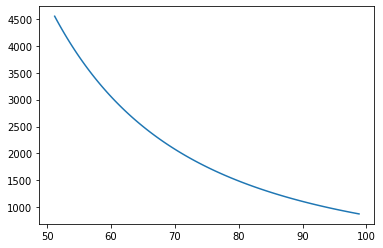

In [5]:
plt.plot(linlog.freqs, linlog()["foregrounds_spectrum"]);

Notice that the `Component` is _called_ here, which produces a dictionary of values. The data added by this particular component is stored under the `<name>_spectrum` key:

In [6]:
linlog.name

'foregrounds'

To determine which key(s) are added to the dictionary by this component, check out:

In [7]:
linlog.provides

['foregrounds_spectrum']

Here we also pause to mention another feature of all `yabf` components and likelihoods: they are _frozen_. That is, they cannot be modified. This may seem overly restrictive, but it makes sense. The likelihood describes a model, which should not be changed over time. The fact that it cannot change also helps with comparing components/likelihoods.

However, a _new_ component (or likelihood) can be created based on an existing one:

In [8]:
new_linlog = linlog.clone(name="fg")
new_linlog.name

'fg'

In [9]:
new_linlog is linlog

False

#### Specifying Parameters

The simplest form of specifying active parameters above is easy, but is usually not very useful: usually you will want to specify attributes of the parameters that define how they are used (eg. priors, default values). To do this, it is typically simplest to pass in a dictionary defining these attributes, as we shall see below. 

There are a few other considerations also when defining parameters -- for instance, some samplers will need to automatically generate a random "reference" set of values to begin sampling, and you may wish to have control over this. Furthermore, some samplers _require_ that parameters be explicitly bounded.

Before we define modified parameter sets, lets take a look at the currently active parameters:

In [10]:
for ap in linlog.active_params:
    print(ap)

Param(name='p0', fiducial=1750.0, min=-inf, max=inf, latex='p_0', ref=None, prior=None, determines=('p0',), transforms=(None,))
Param(name='p1', fiducial=0.0, min=-inf, max=inf, latex='p_1', ref=None, prior=None, determines=('p1',), transforms=(None,))
Param(name='p2', fiducial=0.0, min=-inf, max=inf, latex='p_2', ref=None, prior=None, determines=('p2',), transforms=(None,))
Param(name='p3', fiducial=0.0, min=-inf, max=inf, latex='p_3', ref=None, prior=None, determines=('p3',), transforms=(None,))


The _active_ parameters defined on a component are those that may actively be constrained (i.e. we'll have to pick a value for each of these on every MCMC iteration). Each of them occurs as a `Param` instance, which holds a bunch of information and methods defining the active parameter. 

The full range of possible parameters for the component is defined at instantiation (some components have it defined even before instantiation) by:

In [11]:
linlog.base_parameters

(Parameter(name='beta', fiducial=-2.5, min=-5.0, max=0.0, latex='\\beta'),
 Parameter(name='p0', fiducial=1750.0, min=-inf, max=inf, latex='p_0'),
 Parameter(name='p1', fiducial=0.0, min=-inf, max=inf, latex='p_1'),
 Parameter(name='p2', fiducial=0.0, min=-inf, max=inf, latex='p_2'),
 Parameter(name='p3', fiducial=0.0, min=-inf, max=inf, latex='p_3'))

Notice that each is an instance of the `Parameter` class, not `Param`. The list of `Parameter`s is for all possible parameters, and the list of `Param`s in `active_params` specifies those that are going to be constrained. Simply put, `Param`s inherit information from `Parameter`s, and are able to overwrite that info. Plus they add some more info that only makes sense if you're trying to constrain the parameter. 

Before we get into how to customize this info, let's use our `linlog` instance to view some of the current parameter information:

In [12]:
linlog.fiducial_params

{'p0': 1750.0, 'beta': -2.5, 'p1': 0.0, 'p2': 0.0, 'p3': 0.0}

This dictionary specifies, for all of the parameters (whether active or not), what their value will be if not explicitly specified in a function call. For example, if executing the class itself:

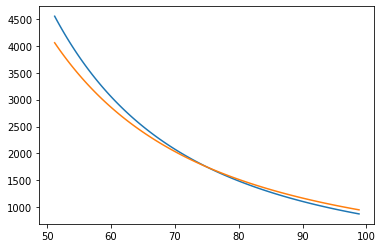

In [13]:
plt.plot(linlog.freqs, linlog()["foregrounds_spectrum"])
plt.plot(linlog.freqs, linlog(params={"beta": -2.2})["foregrounds_spectrum"]);

The first call uses $\beta=-2.5$, as that is its fiducial value. This is clearly important in an MCMC context -- the MCMC sampler only chooses values for the _active_ parameters, so the fiducial values of the non-active parameters must be set prior to beginning the sampling. It is also useful for interactive exploration, where the default parameters for your expectation of the model can be set once, and deviations from this expectation can be explored simply.

The fiducial values for the active parameters are not used at all in an MCMC, though they can be useful to set anyway, because of potential interactive exploration. These will be set in the obvious way: by setting them in the `params=` argument (see below). However, non-active parameters have their fiducial values set directly:

In [14]:
linlog = linlog.clone(fiducial={"beta": -2.45})
print(linlog.fiducial_params)

{'p0': 1750.0, 'beta': -2.45, 'p1': 0.0, 'p2': 0.0, 'p3': 0.0}


The remaining attributes of the `Param`s are as follows. 

`min` and `max` do what they say on the tin: they explicitly bound the range of the parameter. If, in sampling, a value is chosen outside these bounds, the prior is immediately set to `-inf`. Most samplers will not _require_ these to be set (i.e. they can be `+-inf`). However there are circumstances under which they are either required or very useful. For instance, the `polychord` sampler _requires_ them to be non-infinite, as it needs a gross prior volume to weight by. Note that it is a feature proposal for `yabf` v1.1.0 to not require this anymore. Otherwise, the min and max can be an easy way to specify a reference distribution, which is required by eg. the `emcee` sampler (see below).

`prior` should be a statistical distribution. It is assumed that the given object follows the same API as the `scipy.stats` distributions (eg. it has `rvs()`, `pdf()` and `cdf()` methods). Obviously enough, it defines the prior (and therefore only makes sense for active parameters). If the prior is not given at all, it is assumed to be a uniform distribution between `min` and `max`. Most samplers don't really care if the prior is improper (i.e. its integral doesn't converge), and so we don't impose this unless the sampler does.

`ref`, if given, should also be a statistical distribution. It defines an _initial_ "reference" distribution of values for the parameter. Only some samplers may require this (eg. `emcee`), but it is quite fine to define it anyway. By default, it will be set the same as the prior. Note that an improper prior will cause usage of the reference distribution to fail (so this is another reason to set `min` and `max` sensibly if no explicit prior is given). While it may seem like `ref` should always be the same as `prior`, it is actually suggested for `emcee` to use an initial distribution that is much tighter than the prior, and centred around the expected posterior estimate. In principle, the `ref` does _not_ affect the final posterior (but it may affect the efficiency).

The `latex` specifier optionally describes how to write out the parameter name in `latex`.

The final parameters of interest here are `determines` and `transforms`. These determine which underlying `Parameter`s the `Param` will affect, and any transformations applied to it. By default, `determines` is a length-one list including the `Param` name. The contents of `determines` _must_ be names of `Parameter`s defined in the component. Thus, the typical usage is to specify the name of the active param directly as the name of a `Parameter`. 

There are two main reasons you might want to explicitly set `determines`. The first is if you would like a single random parameter to determine more than one `Parameter`. Imagine that we had reason to believe that `p1` and `p2` were deterministically related. Then we could define:

In [15]:
linlog_constrained = linlog.clone(params={"p0": {}, "p12": {"determines": ("p1", "p2")}})
linlog_constrained.active_params

(Param(name='p0', fiducial=1750.0, min=-inf, max=inf, latex='p_0', ref=None, prior=None, determines=('p0',), transforms=(None,)),
 Param(name='p12', fiducial=None, min=-inf, max=inf, latex='p12', ref=None, prior=None, determines=('p1', 'p2'), transforms=(None, None)))

We can see that `p1` and `p2` are co-determined by looking at the output of the hidden method `_fill_params`:

In [16]:
linlog_constrained._fill_params({"p0": 1000, "p12": 10})

<frozendict {'p0': 1000, 'beta': -2.45, 'p1': 10, 'p2': 10, 'p3': 0.0}>

This is not a method that you will usually call -- it is called by any method that receives parameters, before passing those parameters onto its calculation.

The second reason is related: if you have a parameter in another component under the same likelihood that you want to be defined by the same random variable as this, you can call them the same name. For example, say you wanted to fit two different spectra simultaneously, and you expect that while some of the foreground parameters will remain the same between the two, some will be different. You could define two likelihoods, each containing a foreground component like `linlog`. However, if both of the `linlog` components have the same parameter names, only one set of actual random values will be drawn (i.e. you'll force both foreground models to be the same). If you want the parameters to be free, you could re-name a parameter, eg. call `p0` instead `p0_low_band`. To get this to work, you will then need to set `determines = ('p0',)`.

The `transforms` can be used to transform a parameter. The most obvious example is log-space parameters. Perhaps you wish to sample a parameter in log-space. It expects a callable of a single variable. Then you could sample it by setting `transforms = (np.exp, ))`. You'll need one entry for every entry in `determines` (to allow for independent transformations).

Let's re-define our foregrounds using some of these considerations. In particular, since we'll be using polychord and emcee, let's explicitly define `min` and `max` values for each, and also potentially some `ref` and `prior` values:

In [17]:
np.log(1750), np.log(2000)

(7.4673710669175595, 7.600902459542082)

In [96]:
linlog = linlog.clone(
    params={
        "logp0": {
            "min": np.log(1500),
            "max": np.log(2000),
            "prior": stats.norm(np.log(1750), 0.02),
            "ref": stats.norm(np.log(1750), 0.01),
            "determines": ("p0",),
            "latex": r"\log p_0",
            "transforms": (np.exp,),
            "fiducial": np.log(1750),
        },
        "p1": {
            "min": -1000,
            "max": 1000,
            "prior": stats.norm(0, 100),
        },
        "p2": {
            "min": -1000,
            "max": 1000,
            "prior": stats.norm(0, 100),
        },
        "p3": {
            "min": -1000,
            "max": 1000,
            "prior": stats.norm(0, 100),
        },
        "beta": {
            "min": 2.3,
            "max": 2.7,
            "ref": stats.norm(2.5, 0.01),
            "transforms": (lambda x: -x,),
            "fiducial": 2.5,
        },
    }
)

In [97]:
linlog.fiducial_params

{'p0': 1749.9999999999995, 'beta': -2.5, 'p1': 0.0, 'p2': 0.0, 'p3': 0.0}

In [98]:
for ap in linlog.active_params:
    print(ap)

Param(name='logp0', fiducial=7.4673710669175595, min=7.313220387090301, max=7.600902459542082, latex='\\log p_0', ref=<scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdb5f59d240>, prior=<scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdb5f59eef0>, determines=('p0',), transforms=(<ufunc 'exp'>,))
Param(name='p1', fiducial=0.0, min=-1000.0, max=1000.0, latex='p_1', ref=None, prior=<scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdb5f59dc18>, determines=('p1',), transforms=(None,))
Param(name='p2', fiducial=0.0, min=-1000.0, max=1000.0, latex='p_2', ref=None, prior=<scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdb5f59dd68>, determines=('p2',), transforms=(None,))
Param(name='p3', fiducial=0.0, min=-1000.0, max=1000.0, latex='p_3', ref=None, prior=<scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdb5f59d5c0>, determines=('p3',), transforms=(None,))
Param(name='beta', fiducial=2.5, min=2.3, max=2.7, latex='\\beta', ref=<scipy.stats._distn_i

#### Using a Component Interactively

`Component`s really only do one thing: generate data and add it to a dictionary under a given key. They do this when you _call_ them:

In [99]:
linlog_ctx = linlog()

Let's set the key from the class itself:

In [100]:
key = linlog.provides[0]

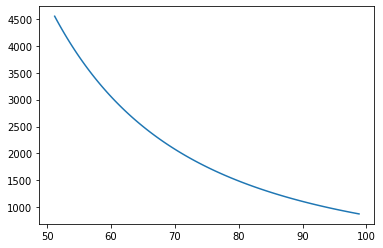

In [101]:
plt.plot(linlog.freqs, linlog_ctx[key]);

You can experiment with different `Parameter`s in the call (note here we're using the `Parameter` names directly):

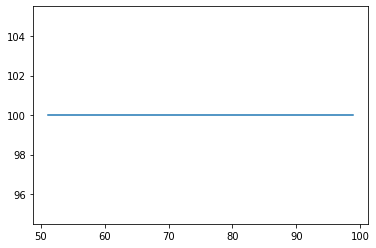

In [102]:
plt.plot(linlog.freqs, linlog(params={"p0": 100, "beta": 0})[key]);

You can also pass non-active parameters. If you pass an active-parameter name, then it will interpret it as one, and perform any transformations applied to it:

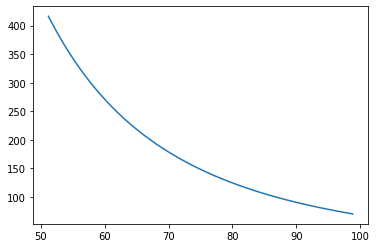

In [103]:
plt.plot(linlog.freqs, linlog(params={"logp0": 5, "beta": 2.7})[key]);

If there are active parameters, you can also pass a simple list of values, which correspond exactly to the ordered tuple of child active parameters:

odict_keys(['logp0', 'p1', 'p2', 'p3', 'beta'])


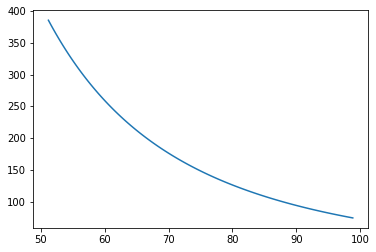

In [104]:
print(linlog.child_active_param_dct.keys())
plt.plot(linlog.freqs, linlog(params=[5, 0, 0, 0, 2.5])[key]);

Note that when using a list like this, the list _must_ be the same length as the `child_active_params` tuple.

Also note that using an active parameter with the same name as a base `Parameter`, but having it transformed, can be confusing. When passing parameters to the computations, if the name is found in `active_params`, it is always transformed, even if you meant to be passing it as a base parameter. 

### Absorption Component

With all that in hand, let's create an absorption-trough component:

In [105]:
eor = ee.eor_models.AbsorptionProfile(
    params={
        "A": {
            "max": 2,  # min is set by default to zero
            "ref": stats.norm(0.5, 0.05),
        },
        "nu0": {
            "min": 60.0,
            "max": 90.0,
            "ref": stats.norm(78, 1),
        },
        "tau": {
            "min": 3,
            "max": 12,
            "ref": stats.norm(7, 0.5),
        },
        "w": {"min": 10.0, "max": 30.0, "ref": stats.norm(17, 1)},
    },
    freqs=freqs,
)

In [106]:
eor.fiducial_params

{'A': 0.5, 'nu0': 75.0, 'tau': 7.0, 'w': 17.0}

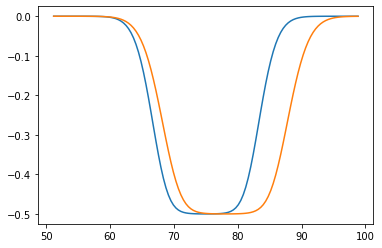

In [107]:
plt.plot(eor.freqs, eor()["eor_spectrum"])
plt.plot(eor.freqs, eor(params=[0.5, 78, 7.0, 20])["eor_spectrum"]);

### Making a Likelihood

The primary kind of likelihood we will want to use for EDGES analysis is a $\chi^2$ likelihood. In our case, we use what we call a `MultiComponentChi2`: basically, it takes a number of components that calculate independent spectra, adds them together, and then compares to data.

In [129]:
lk = ee.likelihoods.MultiComponentChi2(
    name="lk",
    params={
        "sigma": {
            "fiducial": 0.02,
            "min": 0.005,
            "max": 0.5,
            "prior": stats.norm(0.02, 0.005),
            "ref": stats.norm(0.02, 0.001),
        }
    },
    components=(linlog, eor),
)

Here we've passed an explicit prior for $\sigma$, which encodes the amount of thermal noise in the data, which is a priori unknown.

The interface of a `Likelihood` is very similar to a component, and it can be built with many of the same options: `name`, `params`, `fiducial` and `components` (remember that `Component`s can have subcomponents, which are passed the same way). The primary extra argument to a `Likelihood` is `data`: the actual data to which to compare is given as the `data` argument. Notice that we have not given any data to our likelihood. In this case, it will attempt to _simulate_ data given its components. To do this, the `Likelihood` must have a `_mock` method defined, which can take the deterministic simulations from the components and add relevant statistical noise on top. 

The `MultiComponentChi2` does indeed have this method defined -- it adds Gaussian noise according to the value of `sigma`. 

Let's have a look at some of the capabilities of the likelihood. First, we look at the the active parameters. Now, the full list of active parameters includes the children, so we use:

In [130]:
for ap in lk.child_active_params:
    print(ap.name, ap.fiducial)

sigma 0.02
logp0 7.4673710669175595
p1 0.0
p2 0.0
p3 0.0
beta 2.5
A 0.5
nu0 75.0
tau 7.0
w 17.0


This includes the active parameters defined on the likelihood itself (in this case, just `sigma`). In the same way, we can get a list of all the base parameters defined in the likelihood and its children:

In [131]:
lk.child_base_parameters

(Parameter(name='sigma', fiducial=0.013, min=0.0, max=inf, latex='\\sigma'),
 Parameter(name='beta', fiducial=-2.5, min=-5.0, max=0.0, latex='\\beta'),
 Parameter(name='p0', fiducial=1750.0, min=-inf, max=inf, latex='p_0'),
 Parameter(name='p1', fiducial=0.0, min=-inf, max=inf, latex='p_1'),
 Parameter(name='p2', fiducial=0.0, min=-inf, max=inf, latex='p_2'),
 Parameter(name='p3', fiducial=0.0, min=-inf, max=inf, latex='p_3'),
 Parameter(name='A', fiducial=0.5, min=0.0, max=inf, latex='a_{21}'),
 Parameter(name='tau', fiducial=7.0, min=0.0, max=inf, latex='\\tau'),
 Parameter(name='w', fiducial=17.0, min=0.0, max=inf, latex='w'),
 Parameter(name='nu0', fiducial=75.0, min=0.0, max=inf, latex='\\nu_0'))

We can get a list of all the components in the likelihood (recursively) in much the same way:

In [132]:
for name, cmp in lk.child_components.items():
    print(name, cmp.__class__)

foregrounds <class 'edges_estimate.foregrounds.LinLog'>
AbsorptionProfile <class 'edges_estimate.eor_models.AbsorptionProfile'>


We can also check if we are using mock data instead of real data that we passed:

In [133]:
lk.using_mock_data

True

We can calculate priors:

In [134]:
lk.logprior()

-9.199862852011456

and likelihoods:

In [135]:
lk.logl()

314.83679403967574

and posteriors (i.e. the sum of likelihood and prior):

In [136]:
lk.logp()

305.6369311876643

All of these functions optionally accept a `params` argument, which, like a `Component` is passed through `_fill_params` to map the params to their `Parameter`s. Thus one can easily map out a conditional posterior; for example

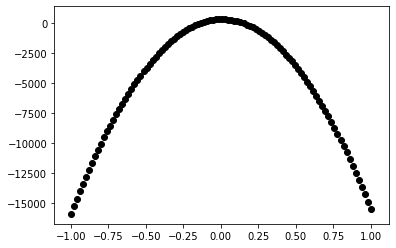

In [137]:
for p1 in np.linspace(-1, 1, 100):
    plt.scatter(p1, lk.logp(params={"p1": p1}), color="k")

Finally, one can _call_ the `Likelihood`:

In [138]:
lk()

(305.6369311876643, [])

This returns a tuple, where the first element is the posterior, and the second element is a list of `derived_quantities`, which can optionally be saved alongside the MCMC chain in some cases. There is an FAQ about this. 

The MCMC routine itself explicitly _calls_ the likelihood, passing in a list of parameter values at each iteration.

As previously mentioned, the calculation of the likelihood is done in three steps. First, the components are evaluated, resulting in a dictionary full of specified keys with associated model data. Second, this data is passed to a dedicated `reduce_model` method, which reduces that model data to its smallest form possible before comparison with data. This output is called the `model`. This `model` is then passed to the likelihood function to do the comparison with data. In the MCMC, the `model` is transitory and is not saved. However, it is often very useful in interactive explorations. For example, let's plot the residuals of our _fiducial_ model:

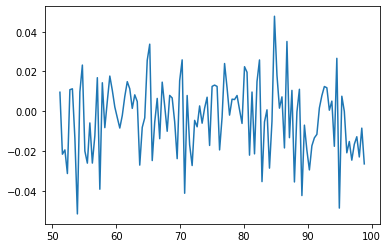

In [139]:
plt.plot(freqs, lk.data - lk.reduce_model());

Notice that we did not give `reduce_model` any arguments: by default it will use the fiducial parameters to construct the component context, and reduce this. Notice also that the output looks exactly like Gaussian noise with $\sigma = 0.02$. This makes sense since it is mock data.

The components can be accessed by name from the likelihood:

In [140]:
fg = lk["foregrounds"]

And because they are static objects, they can be compared:

In [141]:
fg is linlog

True

We cannot update `fg`, as it is also a frozen object, but we can clone it. 

We can directly access the full context data of the components, as computed through the likelihood, by using the `get_ctx` method:

In [142]:
ctx = lk.get_ctx()
print(ctx.keys())

dict_keys(['foregrounds_spectrum', 'eor_spectrum'])


This can be useful for comparing different steps of the analysis interactively. Of course, you can also pass `params` to `get_ctx`, and they will be passed through accordingly. 

## Sampling

There is a higher-level construct than a `LikelihoodContainer`, and it is the `Sampler`. The sampler controls how the likelihood is called in the process of constraining parameters. In this section we'll show the three in-built way to constrain parameters. You can easily define your own, but we don't show you that in this tutorial :-).

In [143]:
from yabf import samplers

### Simple MAP

The simplest and quickest way to get an estimate of the parameters is by running downhill gradient. This is not really "sampling", but attempts to find the mode of the posterior:

In [144]:
result = samplers.run_map(lk)

Keywords passed to `run_map` get passed along to `scipy.optimize.minimize`. Often for complex models, the `run_map` function will not arrive at a satisfactory solution. For instance, in this case, let's look at the result (which is a standard `minimize` result):

In [145]:
result.success

True

In [146]:
print(result.message)
print(list(zip(lk.child_active_param_dct, result.x)))

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
[('sigma', 0.018044213034649335), ('logp0', 7.467370611636622), ('p1', 0.17128170688793437), ('p2', -0.0991606450011168), ('p3', 0.02385599737841966), ('beta', 2.500113196852376), ('A', 0.49943971022364153), ('nu0', 75.00081549825858), ('tau', 7.000598039765134), ('w', 16.997699402574085)]


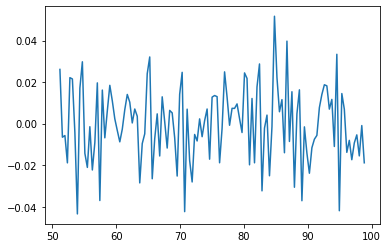

In [147]:
plt.plot(freqs, lk.data - lk.reduce_model(params=result.x));

### Using `emcee`

Using `emcee` is as simple as setting up the `Sampler`:

In [160]:
sampler = samplers.emcee(lk, sampler_kwargs={"nwalkers": 300})

and then calling `sample`:

In [161]:
samples = sampler.sample(nsteps=500)

Removed no burn in


Note here that `sampler_kwargs` passed to the constructor is essentially passed to the internal class that runs the sampling (in this case,`emcee.EnsembleSampler`). The output of `sample` is a `getdist.MCSamples` instance. These have a lot of attached methods for doing analysis. This is probably one of the poorest parts of the `yabf` interface currently, and I am working on it!

The `sample` method can be run multiple times, and each time it will just *continue* sampling, unless the `restart` parameter is set to `True`. 

The `MCSamples` object has a built-in burnin removal method, so let's use that:

In [168]:
samples.removeBurn(60000)  # 200 iterations worth

We can look at the mean of the chain:

In [169]:
for name, mean in zip(lk.child_active_param_dct, samples.getMeans()):
    print(name, mean)

sigma 0.019061963305048064
logp0 7.467369492448913
p1 -47.11303698061074
p2 0.5390028790972495
p3 -0.22595921479298284
beta 2.4730876153810026
A 0.4944495886612746
nu0 75.0020093112595
tau 7.762329310184813
w 16.948006672025567


We can also use `getdist` to make a corner plot:

In [170]:
from getdist.plots import getSubplotPlotter

g = getSubplotPlotter()

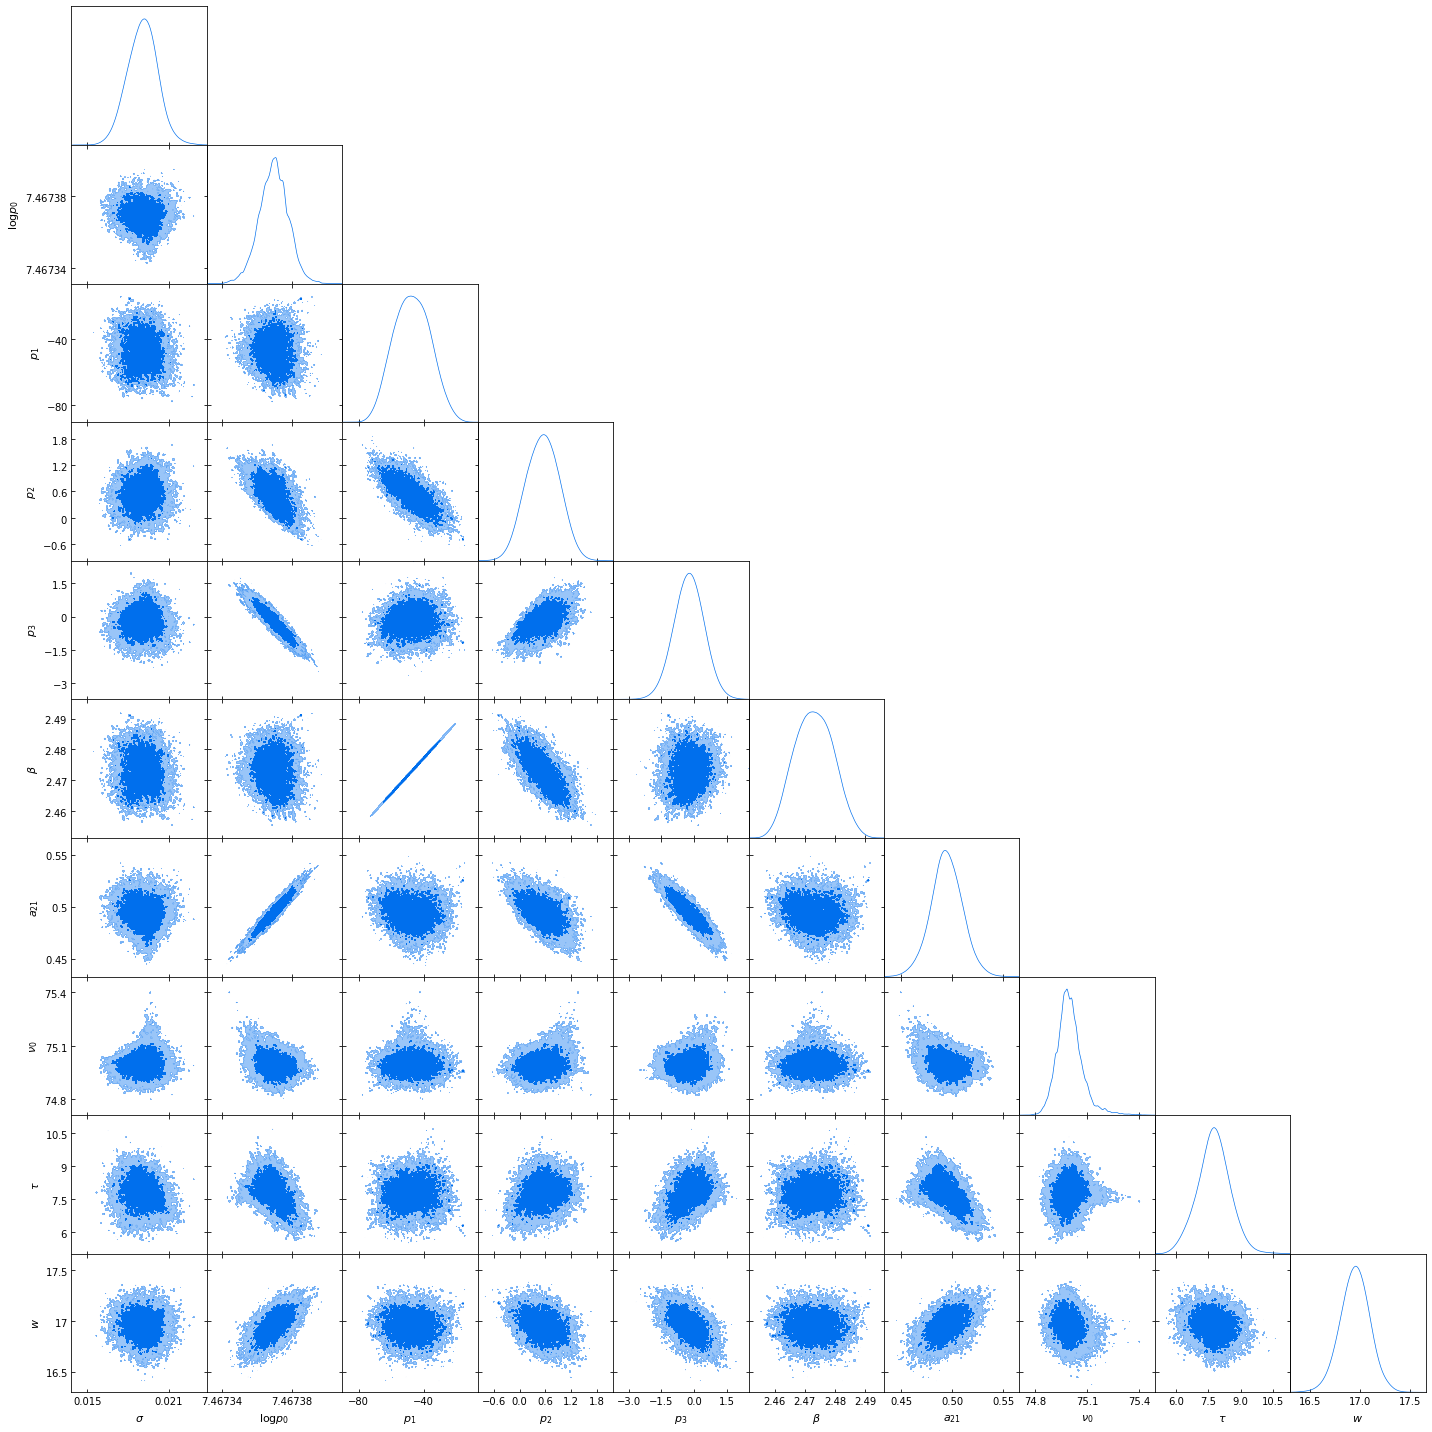

In [172]:
g.triangle_plot(samples, filled=True)

Often `getdist` will issue warnings when making corner plots from `emcee` chains, unless you run _a lot_ of samples. Of course, you could also use the `corner` package to make the plot. We will go through some more methods for exploring output chains in the next major section.

If you want to explore the `EnsembleSampler` object directly, you can access it via:

In [173]:
sampler._sampler

### Using `polychord`

`polychord` can be used in very much the same way (that's the point!). To see the available options to the sampler here, let's import the documentation:

In [174]:
from pypolychord.settings import PolyChordSettings

help(PolyChordSettings)

Help on class PolyChordSettings in module pypolychord.settings:

class PolyChordSettings(builtins.object)
 |  PolyChordSettings(nDims, nDerived, **kwargs)
 |  
 |  PolyChord settings
 |  
 |  For full details of nested sampling and PolyChord, please refer to:
 |  
 |  Parameters
 |  ----------
 |  nDims: int
 |      Dimensionality of the model, i.e. the number of physical parameters.
 |  
 |  nDerived: int
 |      The number of derived parameters (can be 0).
 |  
 |  
 |  Keyword arguments
 |  -----------------
 |  nlive: int
 |      (Default: nDims*25)
 |      The number of live points.
 |      Increasing nlive increases the accuracy of posteriors and evidences,
 |      and proportionally increases runtime ~ O(nlive).
 |  
 |  num_repeats : int
 |      (Default: nDims*5)
 |      The number of slice slice-sampling steps to generate a new point.
 |      Increasing num_repeats increases the reliability of the algorithm.
 |      Typically
 |      * for reliable evidences need num_repeats 

In [178]:
pchord_sampler = samplers.polychord(
    lk,
    output_dir="chains",
    output_prefix="polychord_example",
    sampler_kwargs={
        "nlive": 1024,
        "read_resume": False,
        "precision_criterion": 1.0,  # large value here for a quick example
    },
)

In [179]:
pchord_samples = pchord_sampler.sample()

/home/steven/.local/lib/python3.7/site-packages/pypolychord-1.16-py3.7-linux-x86_64.egg/pypolychord/output.py:188: FutureWarning: read_table is deprecated, use read_csv instead.
  names= initial_col_names)


chains/polychord_example.txt
Removed no burn in


## Exploring Chains

### Importing Chains and Likelihoods

### Analysis Plots

## Writing YAML likelihoods

### Simple Usage

### Features